### Cab-Driver Agent

In [10]:
# Importing libraries
import os
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import glob
import os

env = CabDriver()

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
states_track = collections.defaultdict(dict)

def initialise_states_for_tracking():
    # Initializina Tracking Q-values for a couple of state action pairs
    sample_q_values = [((4,3,2),(4,1)),((0,0,0),(0,4))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        #array to trace state-action pair after every 25th episode         
        states_track[state][action] = []

In [4]:
# Defining a function to save the tracked Q-values in the dictionry
def save_tracking_states():
    print("saving states...")
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_index = env.action_space.index(action)
            Q = prediction[0][action_index]
            states_track[state][action].append(Q)

In [6]:
#Defining a function to save a dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

#### Choice of the Hyper Parameters

We chose to train our model every Episode instead of every step to make use of parallelization  

In [7]:
m = 5 
t = 24  
d = 7   


class DQNAgent:
    def __init__(self, state_size):

        # Define size of state and action
        self.state_size = m+t+d 
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]
      
        # These are hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0009
        self.epsilon_min = 0.00000001
        
        self.batch_size = 2048*3      
        # create replay memory using deque
        self.memory = deque(maxlen=2048*64)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(32,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # get action from model using epsilon-greedy policy
    # Decay in e after we generate each sample from the environment
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
    
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            q_value = q_value[0][poss_actions_index]
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
            
        return action, epsilon
        
        
    # save sample <s,a,r,s'> to the replay memory 
    def append_sample(self, state, action, reward, next_state, terminal_state):
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  
        if len(self.memory) < self.batch_size:
            return
        print('Training...')
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))

        actions, rewards, terminal_states = [], [], []
       
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            actions.append(self.action_space.index(list(action)))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_trans(state)
            update_output[i] = env.state_trans(next_state)
                
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_output)
        
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                   
    def save(self, name):
        self.model.save_weights(name)
        
    def load(self, name):
        self.model.load_weights(name)

### DQN block

In [ ]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")
    
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_space = env.action_space
Time_matrix = np.load("TM.npy")
state_space = env.state_space
start_episode = 0;

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size)

#Loading wights from disk (The training was interupted due to power failure)
# agent.load('./cab_driver.h5')
# start_episode = 2400 # Index of the episode to restart training from

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

initialise_states_for_tracking()

Episodes = 20000
for episode in range(start_episode,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    state_space = env.state_space
    
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards for every 25th episode        
        if terminal_state and episode % 1 == 0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode,"  no of steps:",step_count, "  score:", tot_reward, "  avg score:", round(tot_reward/step_count,4),
                  "  memorylength:", len(agent.memory), "  epsilon:", epsilon)
            
    #For every 25th episode,track the states.
    if episode % 50 == 0:   #every 25 episode
        save_tracking_states()

    if episode % 50 == 0 and episode !=0:
        Rewardname = "saved_pickle_files/Rewards"+str(episode)
        Statesname = "saved_pickle_files/States_tracked"+str(episode)
        save_obj(total_reward,Rewardname)  
        save_obj(states_track,Statesname)
        agent.save("./cab_driver.h5")
        
    #Train the model every episode
    agent.train_model()

episode: 0   no of steps: 127   score: -257.0   avg score: -2.0236   memorylength: 127   epsilon: 1.0
saving states...
episode: 1   no of steps: 149   score: -446.0   avg score: -2.9933   memorylength: 276   epsilon: 0.9991004048875233
episode: 2   no of steps: 141   score: -400.0   avg score: -2.8369   memorylength: 417   epsilon: 0.9982016190464211
episode: 3   no of steps: 140   score: -256.0   avg score: -1.8286   memorylength: 557   epsilon: 0.9973036417486767
episode: 4   no of steps: 137   score: -351.0   avg score: -2.562   memorylength: 694   epsilon: 0.9964064722669286
episode: 5   no of steps: 174   score: -208.0   avg score: -1.1954   memorylength: 868   epsilon: 0.9955101098744694
episode: 6   no of steps: 131   score: -220.0   avg score: -1.6794   memorylength: 999   epsilon: 0.9946145538452457
episode: 7   no of steps: 131   score: -320.0   avg score: -2.4427   memorylength: 1130   epsilon: 0.9937198034538567
episode: 8   no of steps: 142   score: -412.0   avg score: -2.

### Tracking Convergence

In [12]:
# Reading the Rewards and the Q-values from the stored files for ploting

list_of_files = glob.glob('saved_pickle_files/St*')
latest_state_file = max(list_of_files, key=os.path.getctime)

list_of_files = glob.glob('saved_pickle_files/Re*') 
latest_reward_file = max(list_of_files, key=os.path.getctime)

print(latest_state_file)
print(latest_reward_file)

saved_pickle_files/States_tracked19950.pkl
saved_pickle_files/Rewards19950.pkl


### Plotinig Rewards every episode to dicover that the reward incresed with training and then became stable 

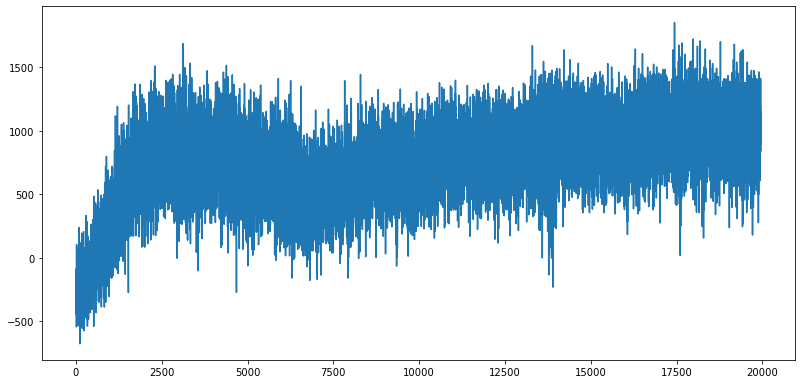

In [14]:
file_2 = open(latest_reward_file,'rb')
avg_reward = pickle.load(file_2)
file_2.close()
plt.rcParams["figure.figsize"] = [13.50, 6.50]

x = range(len(avg_reward))
y = avg_reward



plt.plot(x,y)


### Ploting the tracked Q-Values to see how the Q-Values changed during the training and converged

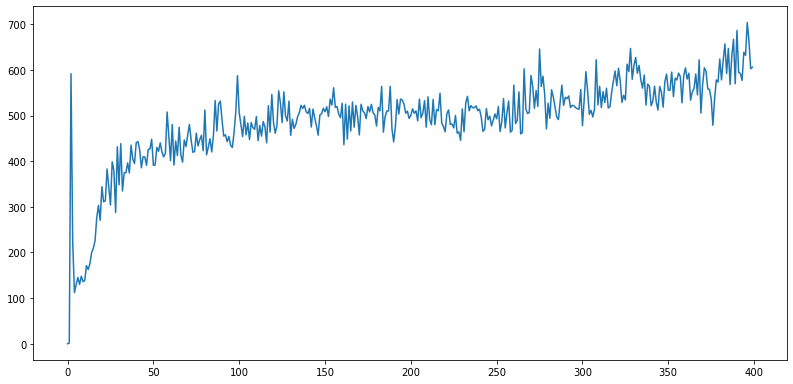

In [17]:
file_2 = open(latest_state_file,'rb')
states_tracked = pickle.load(file_2)
file_2.close()

pair1 = states_tracked[(0,0,0)][(0,4)]
plt.plot(range(len(pair1)),pair1)

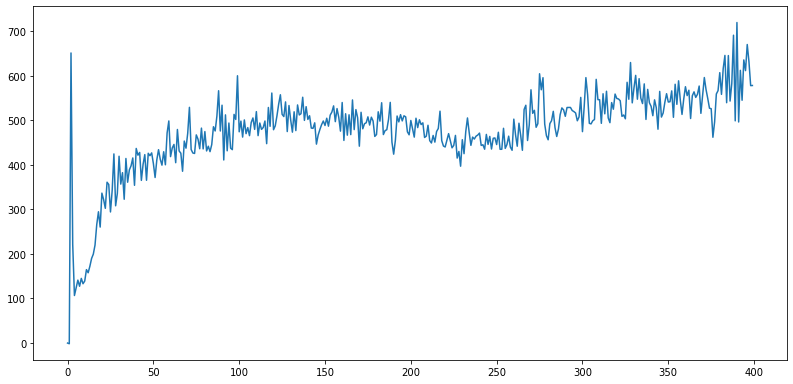

In [18]:
pair2 = states_tracked[(4,3,2)][(4,1)]
plt.plot(range(len(pair2)),pair2)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [19]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

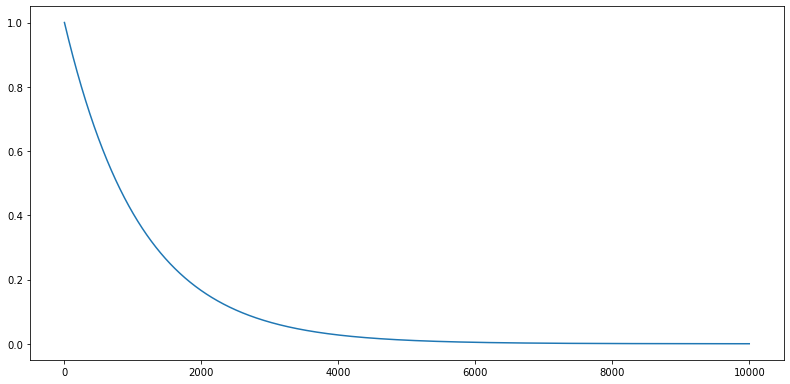

In [20]:
plt.plot(time, epsilon)
plt.show()